### Chess Hi-C analysis
This notebook documents my attempt to detect structural changes using CHESS between Legionella-infected and control Acanthamoeba castellanii.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cooler
import warnings
warnings.filterwarnings('ignore')

os.chdir('/home/cyril/Repos/Acastellanii_legionella_infection/')
hic_samples = pd.read_csv('samples.tsv', sep='\t', comment='#')
clr_ctl = cooler.Cooler('data/output/cool/uninfected_merged_subsampled.cool')
clr_inf = cooler.Cooler('data/output/cool/infected_merged_subsampled.cool')

First, I split the genome into overlapping sliding windows. Windows have a size of 100kb (50 bins) and the step size is 2kb (1 bin). I run chess on the control and infected maps to compute a similarity z-score (z-ssim) between conditions for each window.

In [2]:
%%bash
# Setup dirs
mkdir chess
mkdir chess/features
# Generate chromsizes file
cut -f1,2 data/input/genome/C3.fa.fai > chess/chrom.size
chess pairs chess/chrom.size 100000 2000 chess/100kb_win_2kb_step.bed
chess sim data/output/cool/uninfected_merged_subsampled.cool \
          data/output/cool/infected_merged_subsampled.cool \
          chess/100kb_win_2kb_step.bed \
          chess/100kb_win_2kb_step_legio_results.tsv -p6

mkdir: cannot create directory ‘chess’: File exists
mkdir: cannot create directory ‘chess/features’: File exists
2020-12-09 08:56:37,651 INFO Running '/home/cyril/.local/bin/chess pairs chess/chrom.size 100000 2000 chess/100kb_win_2kb_step.bed'
2020-12-09 08:56:38,353 INFO CHESS version: 0.3.6
2020-12-09 08:56:38,354 INFO FAN-C version: 0.9.9
2020-12-09 08:56:48,594 INFO No entry found with pybedtools. Trying to read from file.
2020-12-09 08:56:48,656 INFO Finished '/home/cyril/.local/bin/chess pairs chess/chrom.size 100000 2000 chess/100kb_win_2kb_step.bed'
2020-12-09 08:56:49,627 INFO Running '/home/cyril/.local/bin/chess sim data/output/cool/uninfected_merged_subsampled.cool data/output/cool/infected_merged_subsampled.cool chess/100kb_win_2kb_step.bed chess/100kb_win_2kb_step_legio_results.tsv -p6'
2020-12-09 08:56:50,238 INFO CHESS version: 0.3.6
2020-12-09 08:56:50,238 INFO FAN-C version: 0.9.9
2020-12-09 08:56:50,240 INFO Loading reference contact data
Expected 100% (5562652 of 5

Now we need to filter windows of interest based on two features:
* SN: Signal to noise ratio
* z-ssim: Z-score of similarity

Interesting windows will have a good signal-to-noise ratio and a low similarity score (changes happening between conditions).

In [2]:
### Chess change detection
chess = pd.read_csv('chess/100kb_win_2kb_step_legio_results.tsv', sep='\t')
wins = pd.read_csv('chess/100kb_win_2kb_step.bed', sep='\t', header=None)
chess['start'] = wins.iloc[:, 1]
# Make start position absolute (not relative to chromosome)
chess['abs_start'] = chess['start'].diff().fillna(0)
chromstart = chess.abs_start < 0
chess.abs_start[chromstart] = 1
chess.abs_start = chess.abs_start.cumsum()
# Remember abs position of chromosome starts
chromstart = chess.abs_start[chromstart]

<IPython.core.display.Javascript object>


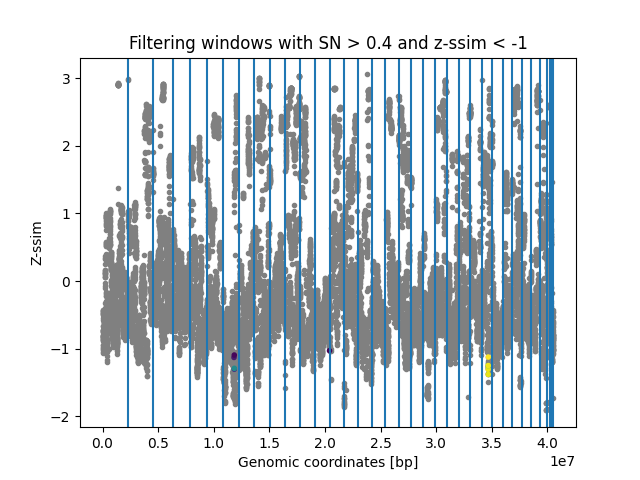

In [4]:
%matplotlib notebook
SN_THRESH = 0.4
ZSSIM_THRESH = -1
hits = (chess.SN > SN_THRESH) & (chess.z_ssim < ZSSIM_THRESH)
plt.scatter(chess.abs_start, chess.z_ssim, c='gray', marker='.')
plt.scatter(chess.abs_start[hits], chess.z_ssim[hits], c=chess.SN[hits], marker='.')
for v in chromstart.values:
    plt.axvline(v)
plt.xlabel("Genomic coordinates [bp]")
plt.ylabel("Z-ssim")
plt.title(f"Filtering windows with SN > {SN_THRESH} and z-ssim < {ZSSIM_THRESH}")
wins.loc[hits, :].to_csv('chess/100kb_win_2kb_step_filtered.bed', header=None, index=False, sep='\t')

I then use `chess extract` to extract differential features in those filtered windows, and `chess crosscorrelate` to cluster these features by similarity.

In [ ]:
%%bash
chess extract chess/100kb_win_2kb_step_filtered.bed \
              data/output/cool/uninfected_merged_subsampled.cool \
              data/output/cool/infected_merged_subsampled.cool \
              chess/features
chess crosscorrelate chess/features/lost_features.tsv \
                     chess/100kb_win_2kb_step_filtered.bed \
                     ./chess/features

Now let's visualize the automatically extracted features.

In [3]:
from scipy.ndimage import zoom
import scipy.ndimage as ndi
def clipped_zoom(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out


def process_img(img):
    img = np.nan_to_num(img, 0)
    img[img > np.percentile(img, 90)] = np.percentile(img, 90)
    img = clipped_zoom(img, 0.7)
    img = ndi.rotate(img, 45, reshape=False)
    middle = int(np.shape(img)[1]/ 2.)
    return img[:middle,:]

<IPython.core.display.Javascript object>


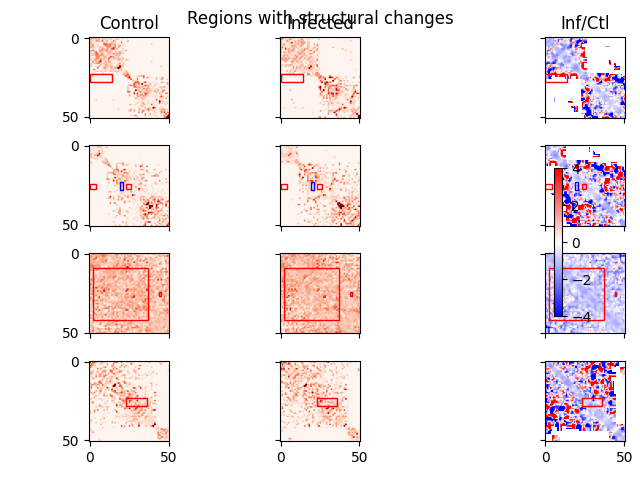

In [121]:
%matplotlib notebook
from chromosight.utils.preprocessing import detrend
from matplotlib.patches import Rectangle
import scipy.ndimage as ndi

# Load features
clusters = pd.read_csv(
    'chess/features/subregions_3_clusters_lost.tsv',
    sep='\t',
    names=['cluster', 'coords', 'ft'])
clusters['coords'] = clusters.coords.str.replace(r':\+-.*', '')
lost_ft = pd.read_csv(
    'chess/features/lost_features.tsv',
    usecols=range(6),
    names=['win', 'ft', 'xmin', 'xmax', 'ymin', 'ymax']
)
gained_ft = pd.read_csv(
    'chess/features/gained_features.tsv',
    usecols=range(6),
    names=['win', 'ft', 'xmin', 'xmax', 'ymin', 'ymax']
)
# Identify all windows (regions) to plot
# Multiple features can be in the same region
wins_ft = np.unique(lost_ft.win)
# Discard adjacent windows...
wins_ft = np.insert(wins_ft[1:][np.diff(wins_ft) > 1], 0, wins_ft[0])

fig, ax = plt.subplots(len(wins_ft), 3, sharex=True, sharey=True)
for i, w in enumerate(wins_ft):
    ft = lost_ft.loc[lost_ft.win == w, 'ft'].values[0]
    chrom, start, end = wins.loc[wins.iloc[:, 6] == w, [0, 1, 2]].values[0]    
    reg = f'{chrom}:{start}-{end}'
    reg_s, reg_e = clr_ctl.extent(reg)
    lost_curr = lost_ft.loc[lost_ft.win == w , :]
    gained_curr = gained_ft.loc[gained_ft.win == w, :]
    mat_ctl = clr_ctl.matrix(sparse=True, balance=True).fetch(reg)
    mat_inf = clr_inf.matrix(sparse=True, balance=True).fetch(reg)
    ax[i, 0].imshow(detrend(mat_ctl).toarray(), cmap='Reds', vmax=4)
    ax[i, 1].imshow(detrend(mat_inf).toarray(), cmap='Reds', vmax=4)
    mat_inf = ndi.gaussian_filter(mat_inf.toarray(), sigma=.5)
    mat_ctl = ndi.gaussian_filter(mat_ctl.toarray(), sigma=.5)
    x = ax[i, 2].imshow(np.log2(mat_inf / mat_ctl), cmap='bwr', vmax=4, vmin=-4)
    for _, r in lost_curr.iterrows():
        for a in ax[i, :]:
            a.add_patch(
                Rectangle(
                    (r.xmin, r.ymin),
                    r.xmax - r.xmin,
                    r.ymax - r.ymin,
                    facecolor='none',
                    edgecolor='red'
                )
            )
    for _, r in gained_curr.iterrows():
        for a in ax[i, :]:
            a.add_patch(
                Rectangle(
                    (r.xmin, r.ymin),
                    r.xmax - r.xmin,
                    r.ymax - r.ymin,
                    facecolor='none',
                    edgecolor='blue'
                )
            )

    
ax[0, 0].set_title("Control")
ax[0, 1].set_title("Infected")
ax[0, 2].set_title("Inf/Ctl")
fig.colorbar(x, ax=ax[:, 2], shrink=0.4, location='right')
plt.tight_layout()
plt.suptitle('Regions with structural changes')
plt.savefig('/home/cyril/chess_out.svg')

When using recommended (pretty stringent) filters, CHESS identifies 3 regions undergoing structural changes during infection. Now let's have a look at genes located in these neighbourhoods

In [164]:
liftover = pd.read_csv('data/tmp/liftoff/neff_c3_liftover.gff', sep='\t', header=None, usecols=[0, 2, 3, 4, 8])
liftover.columns = ['chrom', 'type', 'start', 'end', 'attr']
liftover = liftover.loc[liftover['type'] == 'gene', :]
liftover['accession'] = liftover['attr'].str.replace(r'ID=gene:([^;]*);.*', r'\1')
liftover['desc'] = liftover['attr'].str.replace(r'.*description=([^;]*);.*', r'\1')

The first region spans scaffold_7:982002-1110001 when concatenating all windows involved. In this region, there is a border shift around bin 20. This shift enlarges a domain containing two genes:
* An AMP binding enzyme domain containing protein
* A fascin subfamily protein. [According to NCBi](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd00257) these protein are involved in phosphorylation and bind actin. Could be interesting in the context of Legio infection ? (signaling + vesicle transport)

In [6]:
def query_ucsc_df(query, df):
    r_chrom, bp = query.split(':')
    r_start, r_end = map(int, bp.split('-'))
    result = df.query(f'(chrom == "{r_chrom}") & (end >= {r_start}) & (start < {r_end})')
    return result
    
def map_annot_viz(viz_range, genes_df):
    local_genes = query_ucsc_df(viz_range, genes_df)
    r_start = int(viz_range.split(':')[1].split('-')[0])
    local_genes['bin'] = local_genes['start'] // 2000 - r_start//2000
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
    annot_col = ['grey' if a == 'hypothetical protein' else 'blue' for a in local_genes.desc]
    ax[0].imshow(detrend(clr_ctl.matrix(sparse=True, balance=True).fetch(viz_range)).toarray(), cmap='Reds')
    ax[1].imshow(detrend(clr_inf.matrix(sparse=True, balance=True).fetch(viz_range)).toarray(), cmap='Reds')
    ax[0].scatter(local_genes.bin, local_genes.bin, s=10, c=annot_col)
    ax[1].scatter(local_genes.bin, local_genes.bin, s=10, c=annot_col)
    for i, g in local_genes.iterrows():
        if g.desc != 'hypothetical protein':
            ax[2].annotate(s=g.desc[:50], xy=(0.1, g.bin), fontsize=5)

<IPython.core.display.Javascript object>


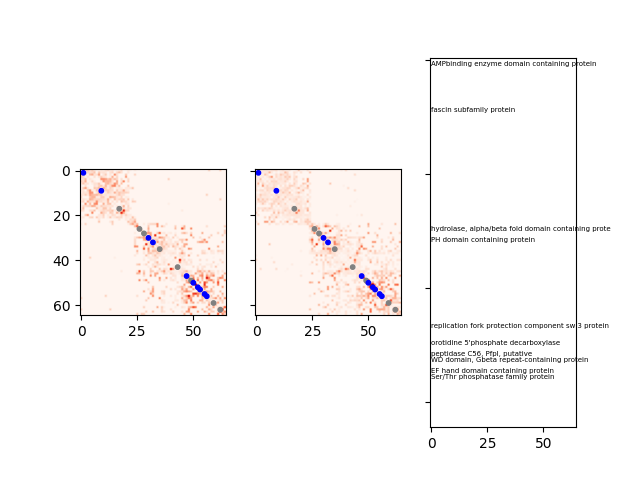

In [123]:
%matplotlib notebook

range_1 = 'scaffold_7:982002-1110001'
map_annot_viz(range_1, liftover)

The second region spans scaffold_13:1308001-1408001 when concatenating all windows involved. The feature is not so clear here, but we can see a strengthening cross pattern around bin 38. The genes that seem to be involved in this cross (i.e. put into contact) are:
* An aminotransferase (class V)
* Hydroxymethyltransferase
* Homoserine acetyltransferase
* A Rho GAP (GTPase) domain containing protein
* A leucine rich repeat domain containing protein.

> Note: In the viscinity of the cross, there are also an Ankyrin repeat containing protein and a DIL domain containing protein([According to interpro](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR002710/), this is an actin-based molecular motor for cargo transport).



<IPython.core.display.Javascript object>


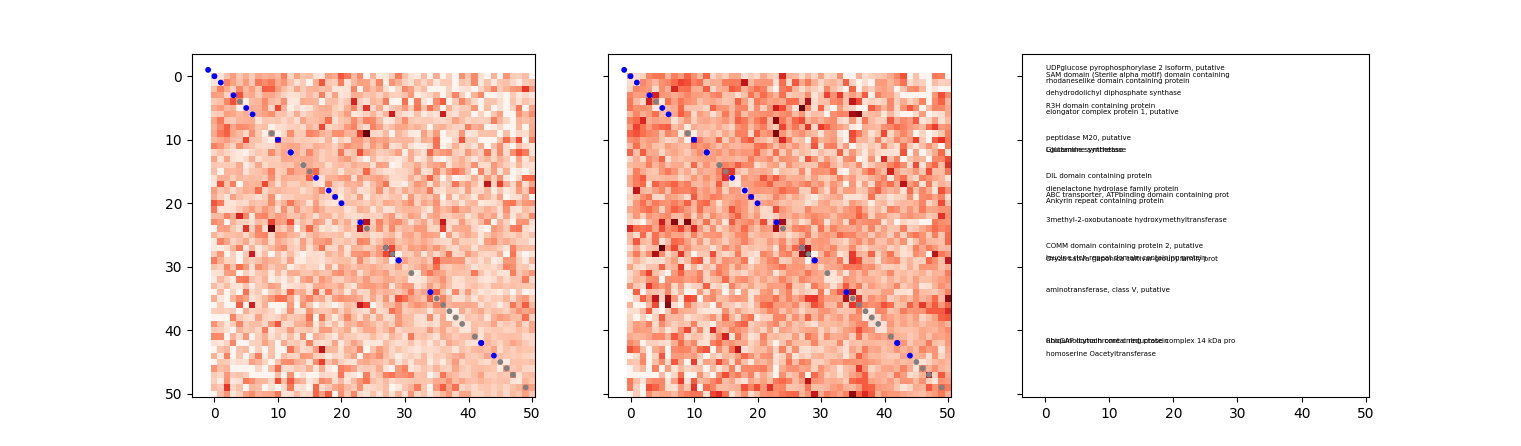

In [124]:
%matplotlib notebook
range_2 = 'scaffold_13:1308001-1408001'
map_annot_viz(range_2, liftover)

The third region spans scaffold_26:590002-698001 when concatenating all windows involved. It's hard to see what change there is, CHESS seems to think it is the tiny looping interaction around bin 35. Which would involve only two genes:
* ribonuclease HI
* A NmrAlike family protein

<IPython.core.display.Javascript object>


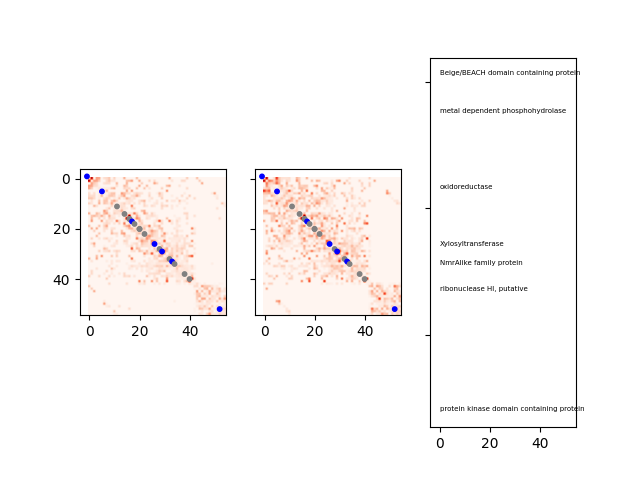

In [125]:
%matplotlib notebook
range_3 = 'scaffold_26:590002-698001'
map_annot_viz('scaffold_26:590002-698001', liftover)
plt.savefig('/home/cyril/region2.svg')

### Separating replicates
The CHESS analysis was done on the merge of 2 replicates. Here I check whether the results hold for both replicates separately. Since the coverage will be lower, I may need to decrease the signal to noise threshold a bit to recover regions.

In [24]:
%%bash
# Setup dirs
mkdir chess/rep1
mkdir chess/rep2
mkdir chess/features
# Generate chromsizes file
cut -f1,2 data/input/genome/C3.fa.fai > chess/chrom.size
chess pairs chess/chrom.size 100000 2000 chess/100kb_win_2kb_step.bed
chess sim data/output/cool/AT419.cool \
          data/output/cool/AT420.cool \
          chess/100kb_win_2kb_step.bed \
          chess/rep1/100kb_win_2kb_step_legio_results.tsv -p6
chess sim data/output/cool/AT421.cool \
          data/output/cool/AT418.cool \
          chess/100kb_win_2kb_step.bed \
          chess/rep2/100kb_win_2kb_step_legio_results.tsv -p6

mkdir: cannot create directory ‘chess/rep1’: File exists
mkdir: cannot create directory ‘chess/rep2’: File exists
mkdir: cannot create directory ‘chess/features’: File exists
2020-12-09 10:53:53,207 INFO Running '/home/cyril/.local/bin/chess pairs chess/chrom.size 100000 2000 chess/100kb_win_2kb_step.bed'
2020-12-09 10:53:53,848 INFO CHESS version: 0.3.6
2020-12-09 10:53:53,848 INFO FAN-C version: 0.9.9
2020-12-09 10:53:55,023 INFO No entry found with pybedtools. Trying to read from file.
2020-12-09 10:53:55,078 INFO Finished '/home/cyril/.local/bin/chess pairs chess/chrom.size 100000 2000 chess/100kb_win_2kb_step.bed'
2020-12-09 10:53:56,005 INFO Running '/home/cyril/.local/bin/chess sim data/output/cool/AT419.cool data/output/cool/AT420.cool chess/100kb_win_2kb_step.bed chess/rep1/100kb_win_2kb_step_legio_results.tsv -p6'
2020-12-09 10:53:56,629 INFO CHESS version: 0.3.6
2020-12-09 10:53:56,629 INFO FAN-C version: 0.9.9
2020-12-09 10:53:56,630 INFO Loading reference contact data
Expe

Globally, replicate experiments are fairly well correlated in terms of window similarity (between conditions). However, when it comes to signal / noise ratio, a subset of windows (i.e. regions) are decorrelated between experiments. This suggest that there is more noise in one experiment than the other.

<IPython.core.display.Javascript object>


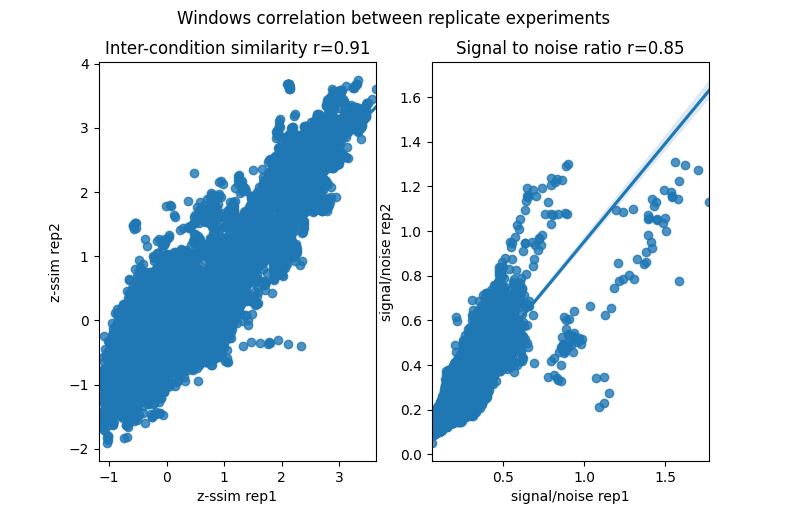

Text(0, 0.5, 'signal/noise rep2')

In [126]:
%matplotlib notebook
import scipy.stats as ss
def prepro_chess(df, wins):
    df['start'] = wins.iloc[:, 1]
    df['abs_start'] = df['start'].diff().fillna(0)
    chromstart = df.abs_start < 0
    df.abs_start[chromstart] = 1
    df.abs_start = df.abs_start.cumsum()
    
    return df

### Chess change detection
chess_r1 = pd.read_csv('chess/rep1/100kb_win_2kb_step_legio_results.tsv', sep='\t')
chess_r2 = pd.read_csv('chess/rep2/100kb_win_2kb_step_legio_results.tsv', sep='\t')
chess_r1 = prepro_chess(chess_r1, wins)
chess_r2 = prepro_chess(chess_r2, wins)

fig, ax = plt.subplots(1, 2)

sns.regplot(x=chess_r1.z_ssim, y=chess_r2.z_ssim, ax=ax[0])
sns.regplot(x=chess_r1.SN, y=chess_r2.SN, ax=ax[1])

plt.suptitle('Windows correlation between replicate experiments')
na_filter = ~np.isnan(chess_r1.z_ssim) & ~np.isnan(chess_r2.z_ssim)
ax[0].set_title(
    'Inter-condition similarity '
    f'r={ss.pearsonr(chess_r1.z_ssim[na_filter], chess_r2.z_ssim[na_filter])[0]:.2f}'
)
ax[1].set_title(
    'Signal to noise ratio '
        f'r={ss.pearsonr(chess_r1.SN[na_filter], chess_r2.SN[na_filter])[0]:.2f}'
)
ax[0].set_xlabel('z-ssim rep1'); ax[0].set_ylabel('z-ssim rep2')
ax[1].set_xlabel('signal/noise rep1'); ax[1].set_ylabel('signal/noise rep2')

If we plot window similarity along the genome for both replicates and highlight windows with a good signal/noise and low similarity for each replicate separately, we see the set of 'candidate' windows differ.
Note I had to lower the SN threshold to include noisier windows in replicate 1...

<IPython.core.display.Javascript object>


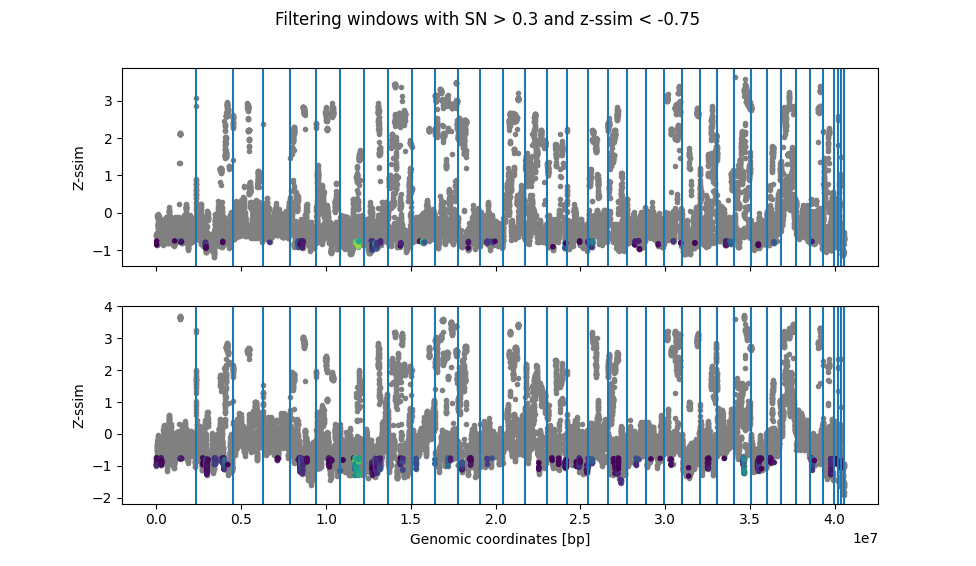

Text(0.5, 0.98, 'Filtering windows with SN > 0.3 and z-ssim < -0.75')

In [127]:
%matplotlib notebook
SN_THRESH = 0.3
ZSSIM_THRESH = -0.75

fig, ax = plt.subplots(2, 1, sharex=True)
for df, a in zip([chess_r1, chess_r2], ax):
    hits = (df.SN > SN_THRESH) & (df.z_ssim < ZSSIM_THRESH)
    a.scatter(df.abs_start, df.z_ssim, c='gray', marker='.')
    a.scatter(df.abs_start[hits], df.z_ssim[hits], c=df.SN[hits], marker='.')
    for v in chromstart.values:
        a.axvline(v)
    a.set_ylabel("Z-ssim")
ax[1].set_xlabel("Genomic coordinates [bp]")
plt.suptitle(f"Filtering windows with SN > {SN_THRESH} and z-ssim < {ZSSIM_THRESH}")
#wins.loc[hits, :].to_csv('chess/100kb_win_2kb_step_filtered.bed', header=None, index=False, sep='\t')

Let's isolate the set of candidate windows common to both replicates:

In [89]:
na_filter = ~np.isnan(chess_r1.z_ssim) & ~np.isnan(chess_r2.z_ssim)
hits_r1 = na_filter & (chess_r1.SN > SN_THRESH) & (chess_r1.z_ssim < ZSSIM_THRESH)
hits_r2 = na_filter &(chess_r2.SN > SN_THRESH) & (chess_r2.z_ssim < ZSSIM_THRESH)

In [90]:
print(
    'Replicate 1 has fewer hits and '
    f'{100*(hits_r1 & hits_r2).sum() / (hits_r1).sum():.2f}% '
    'of them are present in replicate 2. There is a total of '
    f'{(hits_r1 & hits_r2).sum()} common windows.'
)

Replicate 1 has fewer hits and 39.62% of them are present in replicate 2. There is a total of 103 common windows.


In [91]:
wins.loc[hits_r1 & hits_r2, :].to_csv('chess/100kb_win_2kb_step_filtered_inter_rep.bed', header=None, index=False, sep='\t')

Results were not very conclusive with the intersect of replicate candidate windows. Instead, I'll run feature extraction on windows previously selected on the merge.

In [112]:
%%bash
mkdir -p chess/rep1/features
mkdir -p chess/rep2/features
chess extract chess/100kb_win_2kb_step_filtered.bed \
              data/output/cool/AT419.cool \
              data/output/cool/AT420.cool \
              chess/rep1/features
              
chess extract chess/100kb_win_2kb_step_filtered.bed \
              data/output/cool/AT421.cool \
              data/output/cool/AT418.cool \
              chess/rep2/features
#chess crosscorrelate chess/features/lost_features.tsv \
#                     chess/100kb_win_2kb_step_filtered_inter_rep.bed \
#                     ./chess/features

2020-12-09 17:17:16,813 INFO Running '/home/cyril/.local/bin/chess extract chess/100kb_win_2kb_step_filtered.bed data/output/cool/AT419.cool data/output/cool/AT420.cool chess/rep1/features'
2020-12-09 17:17:17,421 INFO CHESS version: 0.3.6
2020-12-09 17:17:17,421 INFO FAN-C version: 0.9.9
2020-12-09 17:17:17,423 INFO Loading reference contact data
2020-12-09 17:17:38,157 INFO Loading region pairs
2020-12-09 17:17:38,157 INFO Applying image filtering to identify specific structures
2020-12-09 17:17:38,252 INFO Results collected
2020-12-09 17:17:38,381 INFO Finished '/home/cyril/.local/bin/chess extract chess/100kb_win_2kb_step_filtered.bed data/output/cool/AT419.cool data/output/cool/AT420.cool chess/rep1/features'
2020-12-09 17:17:39,504 INFO Running '/home/cyril/.local/bin/chess extract chess/100kb_win_2kb_step_filtered.bed data/output/cool/AT421.cool data/output/cool/AT418.cool chess/rep2/features'
2020-12-09 17:17:40,206 INFO CHESS version: 0.3.6
2020-12-09 17:17:40,206 INFO FAN-C v

Both replicates seem to have the feature at scaffold 13 that was detected on the merge, but the feature from scaffold 7 was lost.


In [113]:
lost_r1 = pd.read_csv(
    'chess/rep1/features/lost_features.tsv',
    usecols=range(6),
    names=['win', 'ft', 'xmin', 'xmax', 'ymin', 'ymax']
)
lost_r1

,win,ft,xmin,xmax,ymin,ymax


In [114]:
gained_r1 = pd.read_csv(
    'chess/rep1/features/gained_features.tsv',
    usecols=range(6),
    names=['win', 'ft', 'xmin', 'xmax', 'ymin', 'ymax']
)
gained_r1

,win,ft,xmin,xmax,ymin,ymax
0,10217,0,3,4,24,27
1,10217,1,41,50,24,27
2,17365,2,27,30,25,26


In [115]:


# Load features
lost_r2 = pd.read_csv(
    'chess/rep2/features/lost_features.tsv',
    usecols=range(6),
    names=['win', 'ft', 'xmin', 'xmax', 'ymin', 'ymax']
)
lost_r2

,win,ft,xmin,xmax,ymin,ymax


In [116]:
gained_r2 = pd.read_csv(
    'chess/rep2/features/gained_features.tsv',
    usecols=range(6),
    names=['win', 'ft', 'xmin', 'xmax', 'ymin', 'ymax']
)

In [111]:
gained_ft

,win,ft,xmin,xmax,ymin,ymax
0,10217,0,4,6,21,30
1,10217,1,26,27,23,28


In [117]:
wins.loc[wins.iloc[:, 6] == 10217, :]

,0,1,2,3,4,5,6,7,8,9
10217,scaffold_13,1308001,1408001,scaffold_13,1308001,1408001,10217,.,+,+


Only the feature from the region on scaffold 13 is conserved in both replicates, which makes it the most interesting to look at. Let's have a look at gene expression change in this region.

### Differential expression

Now that we have identified a group of genes with 3D changes, let's check whether their expression also changes during infection.

In [168]:
diff_expr = pd.read_csv('data/output/diff_expr/de_genes.tsv', sep='\t')
diff_expr

,accession,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,c3
0,ACA1_000210,474.681614,-0.673862,0.203958,-3.303921,0.000953,0.002987,NaN
1,ACA1_000220,109.068615,-0.394487,0.181319,-2.175652,0.029581,0.057943,FUN_011364
2,ACA1_000330,344.708090,0.454608,0.111475,4.078131,0.000045,0.000202,NaN
3,ACA1_000530,312.524574,-0.653631,0.179799,-3.635355,0.000278,0.001005,FUN_001668
4,ACA1_000540,312.324909,-0.224862,0.143575,-1.566162,0.117311,0.185845,FUN_001669
...,...,...,...,...,...,...,...,...
16061,ACA1_400590,499.255288,0.220975,0.078907,2.800463,0.005103,0.012838,FUN_004281
16062,ACA1_400800,275.775852,0.321421,0.150552,2.134951,0.032765,0.063347,FUN_004281
16063,ACA1_400910,603.799901,0.331212,0.136062,2.434277,0.014922,0.032327,FUN_004281
16064,ACA1_401020,343.682286,0.428377,0.169451,2.528024,0.011471,0.025754,FUN_004282


In [129]:
# Gather list of gene accessions in any of the three regions reported by Chess
chess_acc = np.unique(query_ucsc_df(range_2, liftover)['accession'])

Visualizing the expression of genes from the region (red) compared to the rest of the genome (grey). Genes which pass differential expression threshold are in clear, while others are blurred.

<IPython.core.display.Javascript object>


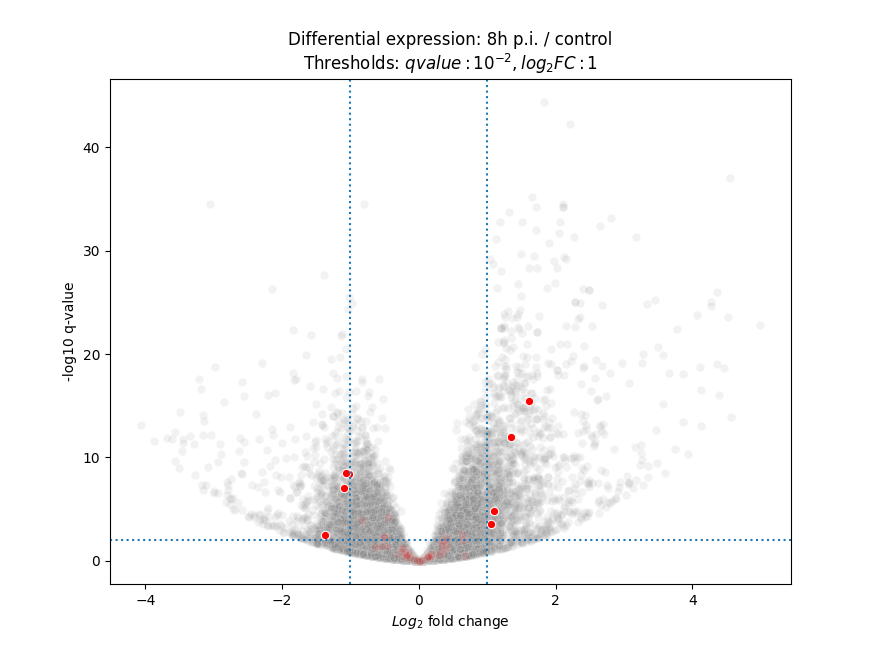

Text(0.5, 1.0, 'Differential expression: 8h p.i. / control\nThresholds: $qvalue: 10^{-2}, log_2FC: 1$')

In [165]:
%matplotlib notebook
FC = 1 # Threshold for log2 fold change
PLOG = 2 # Threshold for -log10(pvalue)
diff_expr['logpval'] = -np.log10(diff_expr.padj)
chess_genes = diff_expr.loc[diff_expr.accession.isin(chess_acc), :]
candidates = chess_genes.loc[(diff_expr.logpval > PLOG) & (diff_expr.log2FoldChange.abs() > FC), :]
sns.scatterplot(data=diff_expr, x='log2FoldChange', y='logpval', color='grey', alpha=0.1)
sns.scatterplot(data=chess_genes, x='log2FoldChange', y='logpval', color='red', alpha=0.1)
sns.scatterplot(data=candidates, x='log2FoldChange', y='logpval', color='red')
plt.axvline(FC, ls=':')
plt.axvline(-FC, ls=':')
plt.axhline(PLOG, ls=':')
plt.xlabel("$Log_2$ fold change")
plt.ylabel("-log10 q-value")
plt.title("Differential expression: 8h p.i. / control\nThresholds: $qvalue: 10^{-2}, log_2FC: 1$")

Here is the list of differentially expressed genes which fall in regions from CHESS:

In [143]:
candidates

,accession,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,c3,logpval
878,ACA1_036920,716.374178,-1.019513,0.161403,-6.316573,2.670000e-10,3.970000e-09,FUN_002670,8.401209
879,ACA1_036930,275.291529,1.611144,0.186655,8.631663,6.050000e-18,3.670000e-16,FUN_002670,15.435334
880,ACA1_036940,443.021634,1.099382,0.233562,4.707018,2.510000e-06,1.540000e-05,FUN_002671,4.812479
881,ACA1_036950,848.081548,1.048619,0.260581,4.024162,5.720000e-05,2.491303e-04,FUN_002671,3.603573
909,ACA1_037430,151.806899,-1.088226,0.189528,-5.741769,9.370000e-09,1.000000e-07,FUN_002690,7.000000
910,ACA1_037440,192.775783,-1.068832,0.168594,-6.339695,2.300000e-10,3.480000e-09,FUN_002690,8.458421
12854,ACA1_307910,137.671202,-1.367851,0.413129,-3.310950,9.297983e-04,2.919106e-03,FUN_002695,2.534750
12855,ACA1_307920,189.487683,1.347380,0.177745,7.580413,3.440000e-14,1.080000e-12,FUN_002694,11.966576


And corresponding annotations (excluding genes without annotations):

In [163]:
print(liftover.loc[liftover.accession.isin(candidates.accession), :].query('desc != "hypothetical protein"').drop('attr', axis=1).to_markdown())

|       | chrom       | type   |   start |     end | accession   | desc                                    |
|------:|:------------|:-------|--------:|--------:|:------------|:----------------------------------------|
| 41434 | scaffold_13 | gene   | 1311135 | 1313828 | ACA1_036920 | rhodaneselike domain containing protein |
| 41454 | scaffold_13 | gene   | 1314564 | 1316069 | ACA1_036930 | dehydrodolichyl diphosphate synthase    |
| 41476 | scaffold_13 | gene   | 1318686 | 1320655 | ACA1_036950 | R3H domain containing protein           |
